# Chest X-ray segmentation using openCV library

First we import the necessary libraries:

In [1]:
import sys
import os
import glob
import numpy as np
import cv2
import scipy.misc
from matplotlib import pyplot as plt

Next, lets look at the data. The CXR (Chest X-ray) images we got from the JSRT (Japanese Society of Radiological Technology). There are 246 images in this free database. Here is an example:

Image shape is: (512, 512)


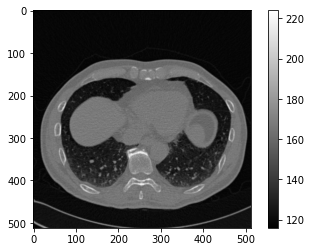

In [2]:
input_dir = 'images/original/'
basename = 'IM-0001-0328.jpg'
filename = input_dir + basename
img = cv2.imread(filename, 0)
print('Image shape is:', img.shape)
plt.imshow(img, cmap='gray')
plt.colorbar()

And now we start the segmentation, following this first image as an example. Later on we shall see the total results of the 246 images.

Our first step was to erase the spinal cord, which can be found by calculating the maximum when summing along the first axis:

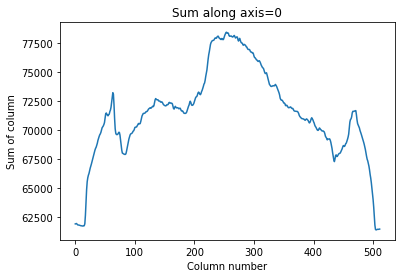

In [3]:
def eraseMax(img, eraseLineCenter=0, eraseLineWidth=30, draw=False):
    sumpix0 = np.sum(img, 0)
    if draw:
        plt.plot(sumpix0)
        plt.title('Sum along axis=0')
        plt.xlabel('Column number')
        plt.ylabel('Sum of column')
    max_r2 = np.int_(len(sumpix0) / 3) + np.argmax(sumpix0[np.int_(len(sumpix0) / 3):np.int_(len(sumpix0) * 2 / 3)])
    cv2.line(img, (max_r2 + eraseLineCenter, 0), (max_r2 + eraseLineCenter, 512), 0, eraseLineWidth)
    return img


img_erased = eraseMax(img, draw=True)

And we get 3 maxima, the largest for the spinal chord.

after erasing we get:

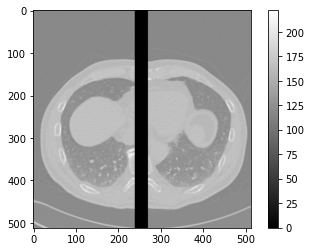

In [4]:
plt.imshow(img_erased, cmap='gray')
plt.colorbar()

Next step was to naromalize the images, and to bring out more detail, using CLAHE:

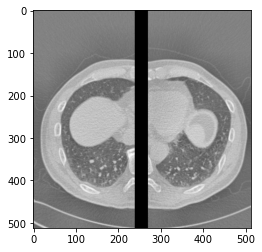

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_erased)
plt.imshow(img_clahe, cmap='gray')

Next we applied openCV's Blackhat kernel:

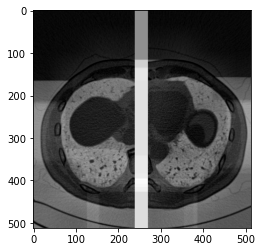

In [6]:
ker = 169
kernel = np.ones((ker, ker), np.uint8)
blackhat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat, cmap='gray')

In the next step we applied a threshold:

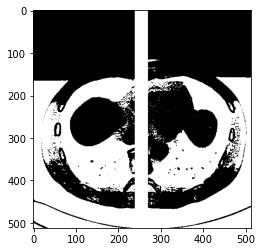

In [7]:
threshold = 45
ret, thresh = cv2.threshold(blackhat, threshold, 255, 0)
plt.imshow(thresh, cmap='gray')

Next we used openCV's corner detection function on the original image, which was useful because the lungs have many small details which can be detected as corners:

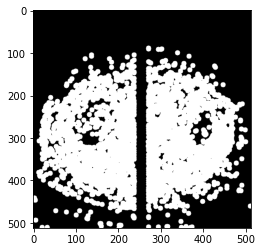

In [8]:
def get_corner_mask(img, maxCorners=3400, qualityLevel=0.001, minDistance=1, Cradius=6):
    corners = cv2.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)
    corners = np.int0(corners)
    cmask = np.zeros(img.shape)
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(cmask, (x, y), Cradius, 1, -1)
    return cmask


cmask = get_corner_mask(img_clahe)
plt.imshow(cmask, cmap='gray')

And so the corner mask gives us the lungs without the background.

So in the next step we multiply the two previous results:

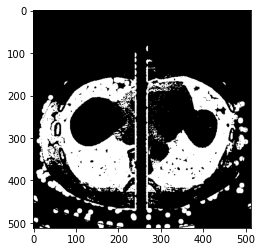

In [9]:
mask = np.multiply(cmask, thresh).astype('uint8')
plt.imshow(mask, cmap='gray')

Next we used a median blur to clean the mask:

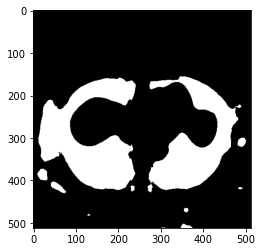

In [10]:
median = cv2.medianBlur(mask, 23)
plt.imshow(median, cmap='gray')

Next we use openCV's contour finder to get only the 2 largest contours, which are the lungs:

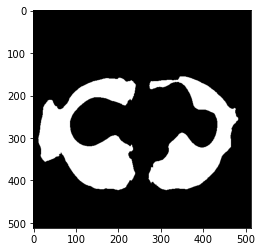

In [11]:
lung_area = 0

def contourMask(image):
    im2, contours, hierc = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area = np.zeros(len(contours))
    for j in range(len(contours)):
        cnt = contours[j]
        area[j] = cv2.contourArea(cnt)
    mask = np.zeros(image.shape)
    cv2.drawContours(mask, contours, np.argmax(area), 255, -1)  #draw largest contour-usually right lung
    temp = np.copy(area[np.argmax(area)])
    area[np.argmax(area)] = 0
    if area[np.argmax(area)] > temp / 10:  #make sure 2nd largest contour is also lung, not 2 lungs connected
        cv2.drawContours(mask, contours, np.argmax(area), 255, -1)  #draw second largest contour
    contours.clear()
    return mask


contour_mask = contourMask(median).astype('uint8')
plt.imshow(contour_mask, cmap='gray')